In [29]:
""" The model code from this file is adapted from the following:
https://github.com/pietrobarbiero/pytorch_explain/blob/master/experiments/elens/mnist.py

Credit to Pietro Barbiero for the original code."""

' The model code from this file is adapted from the following:\nhttps://github.com/pietrobarbiero/pytorch_explain/blob/master/experiments/elens/mnist.py\n\nCredit to Pietro Barbiero for the original code.'

In [23]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
import LEN_Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
from torch.nn.functional import one_hot
import imblearn
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
from sklearn.model_selection import StratifiedKFold, train_test_split
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH
from concurrent.futures import ProcessPoolExecutor
import os
from torch_explain.models.explainer import Explainer
import time
from torchmetrics.functional import precision_recall
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.linear_model import LassoCV
from torch_explain.logic.metrics import formula_consistency
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
files = os.listdir("./categorisedData/")


datasets = [pd.read_csv("./categorisedData/" + file).set_index('PatientID') for file in files]

print(len(datasets))

3


In [3]:
LEN_Scorer = reload(LEN_Scorer)

data = datasets[0]

targetSeries = data['Mortality14Days']

data = data.drop(columns=['Mortality14Days'])

files[0]

'clusteredData.csv'

In [4]:



# print(new_y)

# scorer = LEN_Scorer.Scorer(data=new_x, target=new_y, concept_names=data.columns)

# y_pred, y_test_argmax = scorer.train([20])

# scorer.explain()


# Rebalancing training set
# obj = imblearn.over_sampling.SMOTEN(random_state=0, n_jobs=4)

# print(y_train_unbalanced.numpy().tolist())

# print(sorted(Counter(targetSeries).items()))

# x_train, y_train = obj.fit_resample(data.to_numpy(), targetSeries)

# print(sorted(Counter(y_train).items()))

# print(x_train)

In [25]:
dataTensor = torch.FloatTensor(data.to_numpy())
targetTensor = one_hot(torch.tensor(targetSeries.values).to(torch.long)).to(torch.float)


dataset = TensorDataset(dataTensor, targetTensor)
train_size = int(0.8 * len(dataset))

val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=train_size)
val_loader = DataLoader(val_data, batch_size=val_size)
test_loader = DataLoader(test_data, batch_size=test_size)



n_concepts = next(iter(train_loader))[0].shape[1]
# self.n_concepts = n_concepts


n_classes = targetTensor.shape[1]
# self.n_classes = n_classes

print("Training on {} classes".format(n_classes))

print("Num concepts: {}".format(n_concepts))
print("Num classes: {}".format(n_classes))

base_dir = f'./results/mimicLEN/explainer'
os.makedirs(base_dir, exist_ok=True)

seed_everything(40)

n_splits = 2

# self.n_splits = n_splits

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# self.skf = skf

results_list = []
feature_selection = []
explanations = {i: [] for i in range(n_classes)}

x = dataTensor
y = targetTensor

Global seed set to 40


Training on 2 classes
Num concepts: 120
Num classes: 2


In [27]:



for split, (trainval_index, test_index) in enumerate(skf.split(x.cpu().detach().numpy(),
                                                        y.argmax(dim=1).cpu().detach().numpy())):
    
    # print(x)

    # x = x.cpu()

    # print(x)
    # x = x.to(torch.device("cpu"))
    # y = y.float()
    # y = y.to(torch.device("cpu"))
    # y = one_hot(y.to(torch.int64)).to(torch.float)

    # print(x.shape)
    # print(y, y.shape)


    print(f'Split [{split + 1}/{n_splits}]')
    x_trainval, x_test = torch.FloatTensor(x[trainval_index]), torch.FloatTensor(x[test_index])
    y_trainval, y_test = torch.FloatTensor(y[trainval_index]), torch.FloatTensor(y[test_index])
    x_train_unbalanced, x_val, y_train_unbalanced, y_val = train_test_split(x_trainval, y_trainval, test_size=0.2, random_state=42)
    print(f'{len(y_train)}/{len(y_val)}/{len(y_test)}')


    # Rebalancing training set
    obj = imblearn.over_sampling.SMOTEN(random_state=0, n_jobs=4)

    # print(torch.argmax(y_train_unbalanced, axis=1).numpy())

    print(sorted(Counter(torch.argmax(y_train_unbalanced, axis=1).numpy()).items()))

    x_train, y_train = obj.fit_resample(x_train_unbalanced.numpy(), torch.argmax(y_train_unbalanced, axis=1).numpy())

    print(sorted(Counter(y_train).items()))

    y_train = one_hot(torch.tensor(y_train).to(torch.long)).to(torch.float)
    x_train = torch.FloatTensor(x_train)

    # print(x_train, y_train)

    train_data = TensorDataset(x_train, y_train)
    val_data = TensorDataset(x_val, y_val)
    test_data = TensorDataset(x_test, y_test)
    train_loader = DataLoader(train_data, batch_size=train_size)
    val_loader = DataLoader(val_data, batch_size=val_size)
    test_loader = DataLoader(test_data, batch_size=test_size)

    checkpoint_callback = ModelCheckpoint(dirpath=base_dir, monitor='val_loss', save_top_k=1)

    # Constructs the way that the model will be trained
    trainer = Trainer(max_epochs=200, gpus=1, auto_lr_find=True, deterministic=True,
                    check_val_every_n_epoch=1, default_root_dir=base_dir,
                    weights_save_path=base_dir, callbacks=[checkpoint_callback], enable_progress_bar=False)

    # This is the model itself, which is extended from pytorch_lightning
    model = Explainer(n_concepts=n_concepts, n_classes=n_classes, l1=1e-3, lr=0.01,
                    explainer_hidden=[20], temperature=0.7)

    start = time.time()
    trainer.fit(model, train_loader, val_loader)
    print(f"Gamma: {model.model[0].concept_mask}")
    model.freeze()
    print("\nTesting...\n")
    model_results = trainer.test(model, test_dataloaders=test_loader)
    print("\nExplaining\n")
    results, f = model.explain_class(val_dataloaders=val_loader, train_dataloaders=train_loader, test_dataloaders=test_loader,
                                    topk_explanations=10,
                                    concept_names=data.columns)
    end = time.time()
    print(f"Explaining time: {end - start}")
    results['model_accuracy'] = model_results[0]['test_acc']
    results['extraction_time'] = end

    results_list.append(results)
    extracted_concepts = []
    all_concepts = model.model[0].concept_mask[0] > 0.5
    common_concepts = model.model[0].concept_mask[0] > 0.5
    for j in range(n_classes):
        # print(f[j]['explanation'])
        n_used_concepts = sum(model.model[0].concept_mask[j] > 0.5)
        print(f"Number of features that impact on target {j}: {n_used_concepts}")
        print(f"Explanation for target {j}: {f[j]['explanation']}")
        print(f"Explanation accuracy: {f[j]['explanation_accuracy']}")
        explanations[j].append(f[j]['explanation'])
        extracted_concepts.append(n_used_concepts)
        all_concepts += model.model[0].concept_mask[j] > 0.5
        common_concepts *= model.model[0].concept_mask[j] > 0.5

    results['extracted_concepts'] = np.mean(extracted_concepts)
    results['common_concepts_ratio'] = sum(common_concepts) / sum(all_concepts)

    # Precision, Recall, F1
    print(x_test)
    print("Type:", type(x_test))
    y_pred = torch.argmax(model(x_test), axis=1)
    print("Predictions:", y_pred)
    y_test_argmax = torch.argmax(y_test, axis=1)
    print("Actual:", y_test_argmax)

    prec_rec = precision_recall(y_pred, y_test_argmax, num_classes = n_classes)

    print(prec_rec)

    # compare against standard feature selection
    i_mutual_info = mutual_info_classif(x_trainval, y_trainval[:, 1])
    i_chi2 = chi2(x_trainval, y_trainval[:, 1])[0]
    i_chi2[np.isnan(i_chi2)] = 0
    lasso = LassoCV(cv=5, random_state=0).fit(x_trainval, y_trainval[:, 1])
    i_lasso = np.abs(lasso.coef_)
    i_mu = model.model[0].concept_mask[1]
    # print(model.model[0].concept_mask)
    df = pd.DataFrame(np.hstack([
        i_mu.numpy(),
        # i_mutual_info / np.max(i_mutual_info),
        # i_chi2 / np.max(i_chi2),
        # i_lasso / np.max(i_lasso),
    ]).T, columns=['feature importance'])
    df['method'] = 'explainer'
    # df.iloc[90:, 1] = 'MI'
    # df.iloc[180:, 1] = 'CHI2'
    # df.iloc[270:, 1] = 'Lasso'
    df['feature'] = np.hstack([np.arange(0, n_concepts)])
    feature_selection.append(df)



# self.feature_selection = feature_selection
# # print(self.feature_selection)

# self.df = df
# self.explanations = explanations
# self.results_list = results_list

Split [1/2]
736/96/480
[(0, 371), (1, 12)]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 371), (1, 371)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Gamma: tensor([[False, False, False, False, False, False, False,  True, False,  True,
         False, False, False, False,  True, False, False,  True, False,  True,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True, False, False,
         False, False, False, False, False, False, False,  True, False, False,
         False, False, False, False, False,  True, False, False, False, False],
        [False,  True, False, False,  True, 

c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 35.36166834831238
Number of features that impact on target 0: 11
Explanation for target 0: Arterial BP Mean_Mean_medium | Arterial BP [Diastolic]_Mean_medium | Arterial BP [Diastolic]_Mean_very_low | CVP_Mean_very_low
Explanation accuracy: 0.4824722440772795
Number of features that impact on target 1: 20
Explanation for target 1: Arterial PaCO2_StdDev_low & Arterial pH_StdDev_medium & SVRI_StdDev_very_low & ~Arterial BP [Systolic]_StdDev_very_low & ~CVP_Mean_low
Explanation accuracy: 0.488272921108742
tensor([[0., 1., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
Type: <class 'torch.Tensor'>
Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 4.9 K 
-------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers

[(0, 368), (1, 368)]


c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Gamma: tensor([[False, False, False, False, False, False, False, False, False,  True,
         False,  True, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,  True,
          True, False, False, False, False, False, False,  True, False, False,
         False, False, False, False, False,  True, False, False, False, False,
          True, False, False, False, False, False, False,  True, False, False,
         False, False,  True, False,  True, False, False,  True,  True, False,
          True, False, False, False, False,  True, False,  True, False, False,
         False, False,  True, False, False, False,  True, False, False, False,
         False, False, False, False, False, False, False,  True, False, False,
         False,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True, False, False],
        [False, False, False, False, False, 

c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Explaining time: 115.99576950073242
Number of features that impact on target 0: 21
Explanation for target 0: ~CVP_Mean_very_high
Explanation accuracy: 0.5956413127745714
Number of features that impact on target 1: 14
Explanation for target 1: ~Arterial BP [Diastolic]_StdDev_medium & ~Arterial PaCO2_Mean_very_low & ~CVP_StdDev_low & ~CVP_StdDev_very_high & ~Ionized Calcium_StdDev_low
Explanation accuracy: 0.46980994465657044
tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Type: <class 'torch.Tensor'>
Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0

{0: ['Arterial BP Mean_Mean_medium | Arterial BP [Diastolic]_Mean_medium | Arterial BP [Diastolic]_Mean_very_low | CVP_Mean_very_low', '~CVP_Mean_very_high'], 1: ['Arterial PaCO2_StdDev_low & Arterial pH_StdDev_medium & SVRI_StdDev_very_low & ~Arterial BP [Systolic]_StdDev_very_low & ~CVP_Mean_low', '~Arterial BP [Diastolic]_StdDev_medium & ~Arterial PaCO2_Mean_very_low & ~CVP_StdDev_low & ~CVP_StdDev_very_high & ~Ionized Calcium_StdDev_low']}
['Arterial BP Mean_Mean_medium | Arterial BP [Diastolic]_Mean_medium | Arterial BP [Diastolic]_Mean_very_low | CVP_Mean_very_low', '~CVP_Mean_very_high']
['Arterial PaCO2_StdDev_low & Arterial pH_StdDev_medium & SVRI_StdDev_very_low & ~Arterial BP [Systolic]_StdDev_very_low & ~CVP_Mean_low', '~Arterial BP [Diastolic]_StdDev_medium & ~Arterial PaCO2_Mean_very_low & ~CVP_StdDev_low & ~CVP_StdDev_very_high & ~Ionized Calcium_StdDev_low']
Feature selection:       feature importance     method  feature
0                 False  explainer        0
1    

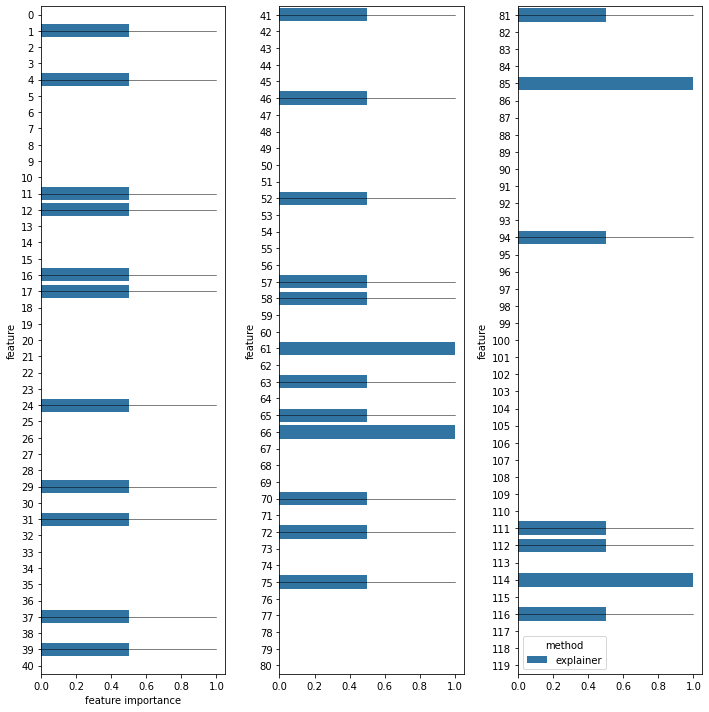

Split [1/2]
Split [2/2]
Random forest scores: 0.9614191892832289 (+/- 0.0010025226165622514)
Decision tree scores: 0.9238582985386221 (+/- 0.019891701461377864)
Mu net scores (model): 0.9426344037055969 (+/- 0.01925537779808109)
Mu net scores (exp): 0.5090491056542908 (+/- 0.033483660023101665)


In [28]:
base_dir = f'./results/mimicLEN/explainer'

consistencies = []
print(explanations)
for j in range(n_classes):
    if explanations[j][0] is None:
        continue
    consistencies.append(formula_consistency(explanations[j]))
explanation_consistency = np.mean(consistencies)

feature_selection = pd.concat(feature_selection, axis=0)

print("Feature selection: ", feature_selection)

f1 = feature_selection[feature_selection['feature'] <= n_concepts//3]
f2 = feature_selection[(feature_selection['feature'] > n_concepts//3) & (feature_selection['feature'] <= (n_concepts*2)//3)]
f3 = feature_selection[feature_selection['feature'] > (n_concepts*2)//3]

plt.figure(figsize=[10, 10])
plt.subplot(1, 3, 1)
ax = sns.barplot(y=f1['feature'], x=f1.iloc[:, 0],
                hue=f1['method'], orient='h', errwidth=0.5, errcolor='k')
ax.get_legend().remove()
plt.subplot(1, 3, 2)
ax = sns.barplot(y=f2['feature'], x=f2.iloc[:, 0],
                hue=f2['method'], orient='h', errwidth=0.5, errcolor='k')
plt.xlabel('')
ax.get_legend().remove()
plt.subplot(1, 3, 3)
sns.barplot(y=f3['feature'], x=f3.iloc[:, 0],
            hue=f3['method'], orient='h', errwidth=0.5, errcolor='k')
plt.xlabel('')
plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'barplot_mimic.png'))
plt.savefig(os.path.join(base_dir, 'barplot_mimic.pdf'))
plt.show()

# print(feature_selection.iloc[:, 1], feature_selection.iloc[:, 0])

# plt.figure(figsize=[6, 4])
# sns.boxplot(x=feature_selection.iloc[:, 1], y=feature_selection.iloc[:, 0])
# plt.tight_layout()
# plt.savefig(os.path.join(base_dir, 'boxplot_mimic.png'))
# plt.savefig(os.path.join(base_dir, 'boxplot_mimic.pdf'))
# plt.show()


results_df = pd.DataFrame(results_list)
results_df['explanation_consistency'] = explanation_consistency
results_df.to_csv(os.path.join(base_dir, 'results_aware_mimic.csv'))
results_df


results_df.mean()

results_df.sem()

x = dataTensor
y = targetTensor

dt_scores, rf_scores = [], []
for split, (trainval_index, test_index) in enumerate(
        skf.split(x.cpu().detach().numpy(), y.argmax(dim=1).cpu().detach().numpy())):
    print(f'Split [{split + 1}/{n_splits}]')
    x_trainval, x_test = x[trainval_index], x[test_index]
    y_trainval, y_test = y[trainval_index].argmax(dim=1), y[test_index].argmax(dim=1)

    dt_model = DecisionTreeClassifier(max_depth=5, random_state=split)
    dt_model.fit(x_trainval, y_trainval)
    dt_scores.append(dt_model.score(x_test, y_test))

    rf_model = RandomForestClassifier(random_state=split)
    rf_model.fit(x_trainval, y_trainval)
    rf_scores.append(rf_model.score(x_test, y_test))

print(f'Random forest scores: {np.mean(rf_scores)} (+/- {np.std(rf_scores)})')
print(f'Decision tree scores: {np.mean(dt_scores)} (+/- {np.std(dt_scores)})')
print(f'Mu net scores (model): {results_df["model_accuracy"].mean()} (+/- {results_df["model_accuracy"].std()})')
print(
    f'Mu net scores (exp): {results_df["explanation_accuracy"].mean()} (+/- {results_df["explanation_accuracy"].std()})')


In [18]:
# Testing on non-rebalanced data

print(f1_score(y_test_argmax.numpy(), y_pred.numpy()))
print(recall_score(y_test_argmax.numpy(), y_pred.numpy()))
print(precision_score(y_test_argmax.numpy(), y_pred.numpy()))

0.19047619047619052
0.23529411764705882
0.16


In [19]:
precision_recall_fscore_support(y_test_argmax.numpy(), y_pred.numpy())

(array([0.97136564, 0.16      ]),
 array([0.95454545, 0.23529412]),
 array([0.9628821 , 0.19047619]),
 array([462,  17], dtype=int64))

In [20]:
print("Minority class correct: " + str(torch.sum(torch.logical_and((y_pred == 1), (y_test_argmax == 1))).item()))

Minority class correct: 4
